In [1]:
from glob import glob
import os
import warnings

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from era_data import TabletPeriodDataset, pad_zeros

warnings.filterwarnings("ignore", "is_categorical_dtype")

# Explore data size

In [2]:
! du -h output/images_preprocessed

5.7G	output/images_preprocessed


In [3]:
IMG_FNS = glob('output/images_preprocessed/*.png')
IDS = {int(os.path.basename(fn).rstrip('.png')) for fn in IMG_FNS}
len(IMG_FNS), len(IDS)

(94936, 94936)

# Load Data

In [4]:
folder_path = 'output/images_preprocessed'
image_names = [os.path.splitext(file)[0] for file in os.listdir(folder_path) if file.endswith('.png')]

In [5]:
df = pd.read_csv('output/cdli_catalogue_data.csv')

In [6]:
df['id_text_normed']=[pad_zeros(x) for x in df['id_text']]

In [7]:
df = df[df['id_text_normed'].isin(image_names)]

In [8]:
df=df[(df['period_normed'].isin(TabletPeriodDataset.PERIOD_INDICES))&(df['era'].notnull())]

In [9]:
df.drop_duplicates('period_normed').dropna(subset='era').set_index('period_normed')['era']

period_normed
Uruk III                   early_bronze
ED I-II                    early_bronze
Uruk IV                    early_bronze
ED IIIa                    early_bronze
Proto-Elamite              early_bronze
ED IIIb                    early_bronze
Ur III                     early_bronze
Old Akkadian               early_bronze
Old Babylonian          mid_late_bronze
Early Old Babylonian    mid_late_bronze
Lagash II                  early_bronze
Neo-Babylonian                     iron
Middle Babylonian       mid_late_bronze
Old Assyrian            mid_late_bronze
Neo-Assyrian                       iron
Ebla                       early_bronze
Hellenistic                        iron
Achaemenid                         iron
Middle Assyrian         mid_late_bronze
Middle Elamite          mid_late_bronze
Middle Hittite          mid_late_bronze
Name: era, dtype: object

In [10]:
df.shape

(94357, 15)

In [11]:
df.head()

,genre,id,id_text,period,photo_up,subgenre,period_normed,era,provenience_normed,height,width,thickness,year_range,provenience,id_text_normed
0,Lexical,661,713,Uruk III (ca. 3200-3000 BC),600ppi 20160630,Archaic Vessels and Garments (witness),Uruk III,early_bronze,mod. Jemdet Nasr,106,79,25,3200-3000 BC,uncertain (mod. Jemdet Nasr),000713
1,Lexical,662,714,Uruk III (ca. 3200-3000 BC),600ppi 20160630,Archaic Geography (witness),Uruk III,early_bronze,mod. Jemdet Nasr,83,58,18,3200-3000 BC,uncertain (mod. Jemdet Nasr),000714
2,Lexical,663,723,ED I-II (ca. 2900-2700 BC),600ppi 20160630,ED Lu2 A (witness),ED I-II,early_bronze,Ur,?,?,?,2900-2700 BC,Ur (mod. Tell Muqayyar),000723
3,Lexical,664,724,ED I-II (ca. 2900-2700 BC),600ppi 20160913,Archaic Fish (witness),ED I-II,early_bronze,Ur,?,?,?,2900-2700 BC,Ur (mod. Tell Muqayyar),000724
4,Lexical,668,728,ED I-II (ca. 2900-2700 BC),600ppi 20160630,ED Lu2 A (witness),ED I-II,early_bronze,Ur,?,?,?,2900-2700 BC,Ur (mod. Tell Muqayyar),000728


In [12]:
df[df.era.isna()].period_normed.value_counts()

Series([], Name: count, dtype: int64)

In [13]:
df_img = df[df.id_text.isin(IDS)].copy()

In [14]:
len(IMG_FNS), df_img.shape[0]

(94936, 94357)

# Plot Data Distributions

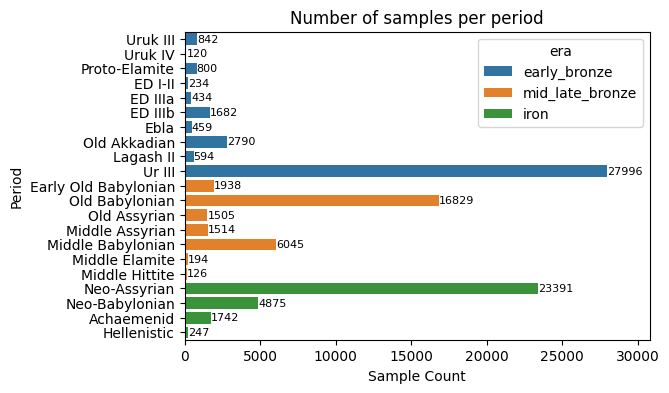

In [31]:
data_period = pd.DataFrame(df.period_normed.value_counts()).reset_index()
data_period.columns = ['period_normed', 'count']

# Create the barplot with order of the periods
plt.figure(figsize=(6, 4)) 
barplot = sns.countplot(y='period_normed', hue='era', data=df[(df['period_normed'].isin(TabletPeriodDataset.PERIOD_INDICES))&(df['era'].notnull())],
                      order=['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                             'Ur III', 'Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                             'Middle Babylonian', 'Middle Elamite', 'Middle Hittite', 'Neo-Assyrian', 
                             'Neo-Babylonian', 'Achaemenid', 'Hellenistic'], dodge=False)

plt.ylabel('Period')
plt.xlabel('Sample Count')

plt.title('Number of samples per period')
plt.xlim(right=data_period['count'].max() * 1.1)
for patch in barplot.patches:
    count = patch.get_width()
    if count > 0:
        plt.text(count, patch.get_y() + patch.get_height() / 2., f'{int(count)}', ha = 'left', va = 'center', fontsize=8, color = 'black')

plt.show()
# plt.savefig(period_pdf_path, format='pdf')
# plt.close()  

In [26]:
inverse_mapping = {}
for genre, index in TabletPeriodDataset.GENRE_INDICES.items():
    if index not in inverse_mapping:  
        inverse_mapping[index] = genre

simplified_genre_mapping = {genre: inverse_mapping[TabletPeriodDataset.GENRE_INDICES
[genre]] for genre in TabletPeriodDataset.GENRE_INDICES}

df['simplified_genre'] = df['genre'].map(simplified_genre_mapping)

In [27]:
data_genre = pd.DataFrame(df.simplified_genre.value_counts()).reset_index()

''

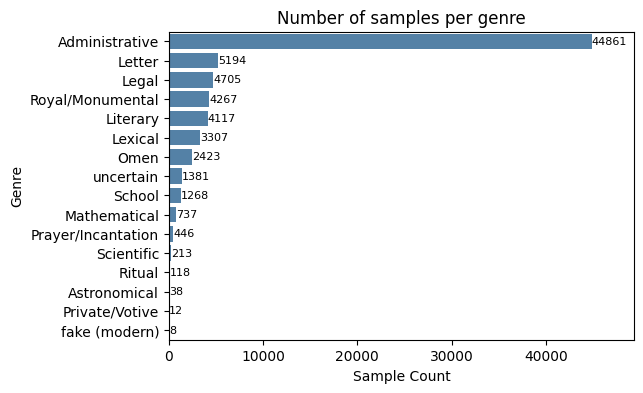

In [36]:
plt.figure(figsize=(6, 4)) 

barplot_genre = sns.barplot(y = 'simplified_genre', x='count', data = data_genre[data_genre['simplified_genre'].isin(TabletPeriodDataset.GENRE_INDICES)], color='steelblue')
plt.ylabel('Genre')
plt.xlabel('Sample Count')

plt.title('Number of samples per genre')
plt.xlim(right=data_genre['count'].max() * 1.1)
for patch in barplot_genre.patches:
    count = patch.get_width()
    if count > 0:
        plt.text(count, patch.get_y() + patch.get_height() / 2., f'{int(count)}', ha = 'left', va = 'center', fontsize=8, color = 'black')
;

In [17]:
df_img.era.value_counts()

era
early_bronze       35951
iron               30255
mid_late_bronze    28151
Name: count, dtype: int64

# Plot Sample Data

In [18]:
def get_fn(ID):
    return f'output/images_preprocessed/{ID}.png'

genre                            Administrative
id                                       165211
id_text                                  325991
period                Ur III (ca. 2100-2000 BC)
photo_up                        600ppi 20160630
subgenre                                    NaN
period_normed                            Ur III
era                                early_bronze
provenience_normed                       Nippur
height                                       62
width                                        49
thickness                                   NaN
year_range                         2100-2000 BC
provenience                Nippur (mod. Nuffar)
id_text_normed                           325991
Name: 54960, dtype: object


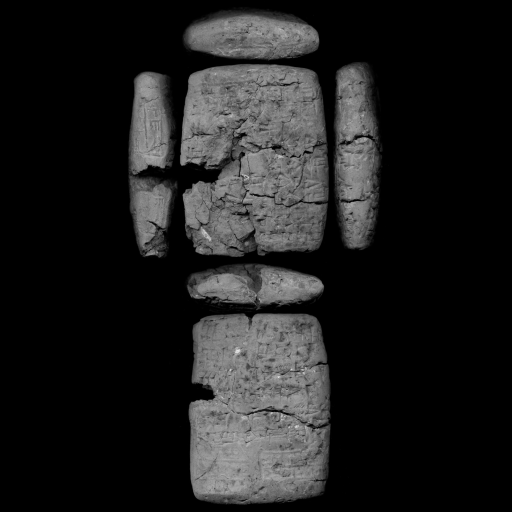

In [19]:
row = df_img.sample().iloc[0]
print(row)
fn = get_fn(row.id_text_normed)
Image.open(fn)